In [1]:
#run patches through vae from scratch

In [50]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture

from particle_detection.data.data_pipeline import create_dataloaders

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


In [53]:
image_dir = "../data"
patch_dir = "../128x128_patches_dataset"
image_size = (128, 128)

batch_size = 128

train_patches, test_patches = create_dataloaders(data_dir=patch_dir, image_size=(128,128) , batch_size=128)
train_images, test_images = create_dataloaders(data_dir=image_dir, image_size=(2048,2048), batch_size=8)

In [54]:
class VAE(nn.Module):
    def __init__(self, latent_dim=256, input_channels=1):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim

        # channels 32 -> 64 -> 128 -> 256 -> 512
        # image size 64 -> 32 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        # dynamically compute feature map size
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 128, 128)
            encoded_output = self.encoder(dummy_input)
            self.flattened_dim = encoded_output.numel()
            self.encoded_shape = encoded_output.shape

        # latent space mapping
        self.fc_mu = nn.Linear(self.flattened_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flattened_dim, latent_dim)

        # channels 256 -> 128 -> 64 -> 32 -> 1
        # image size 8 -> 16 -> 32 -> 64 -> 128
        self.fc_decoder = nn.Linear(latent_dim, self.flattened_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # reparameterization trick: z = mu + std * epsilon
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # encode -> reparameterize -> decode
        x = self.encoder(x).view(x.size(0), -1)

        # latent space
        mu = self.fc_mu(x)
        #logvar = torch.clamp(self.fc_logvar(x), min=-10, max=10)
        #logvar= self.fc_logvar(x)
        logvar = 10 * torch.tanh(self.fc_logvar(x))
        z = self.reparameterize(mu, logvar)

        # decode
        x = self.fc_decoder(z).view(-1, *self.encoded_shape[1:])  # Reshape back to feature map size
        x = self.decoder(x)
        return x, mu, logvar

    def encode(self, x):
        # get latent space mu
        x = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(x)


def create_vae(latent_dim=256, input_channels=1):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    vae = VAE(latent_dim=latent_dim, input_channels=input_channels).to(device)
    return vae

In [55]:
def train_vae(model, train_loader, optimizer, num_epochs, device="cuda"):
    model.to(device)
    model.train()

    kl_losses = []
    recon_losses = []
    total_losses = []
    
    for epoch in range(num_epochs):
        epoch_kl_loss = 0.0
        epoch_recon_loss = 0.0
        epoch_total_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, batch in enumerate(progress_bar):
            batch = batch.to(device)

            reconstructed, mu, logvar = model(batch)
            total_loss, recon_loss, kl_loss = vae_loss(reconstructed, batch, mu, logvar, beta=5.0)

            total_loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            optimizer.zero_grad()

            epoch_kl_loss += kl_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_total_loss += total_loss.item()

            progress_bar.set_postfix(loss=f"{total_loss.item():.4f}")

        kl_losses.append(epoch_kl_loss / len(train_loader))
        recon_losses.append(epoch_recon_loss / len(train_loader))
        total_losses.append(epoch_total_loss / len(train_loader))

    print(f"Epoch {epoch+1}: Total Loss: {total_losses[-1]:.4f}, KL Loss: {kl_losses[-1]:.4f}, Recon Loss: {recon_losses[-1]:.4f}")
    
    return kl_losses, recon_losses, total_losses

In [56]:
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    
    recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

In [57]:
#print(vae.module.encoder)

In [58]:
vae = create_vae(latent_dim=128)
vae = nn.DataParallel(vae).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

kl_losses, recon_losses, total_losses = train_vae(model=vae, train_loader=train_patches, optimizer=optimizer, num_epochs=20, device="cuda")

Epoch 20/20: 100%|██████████████████████████████| 187/187 [00:37<00:00,  4.94it/s, loss=217.5733]

Epoch 20: Total Loss: 213.1805, KL Loss: 9.4858, Recon Loss: 165.7517


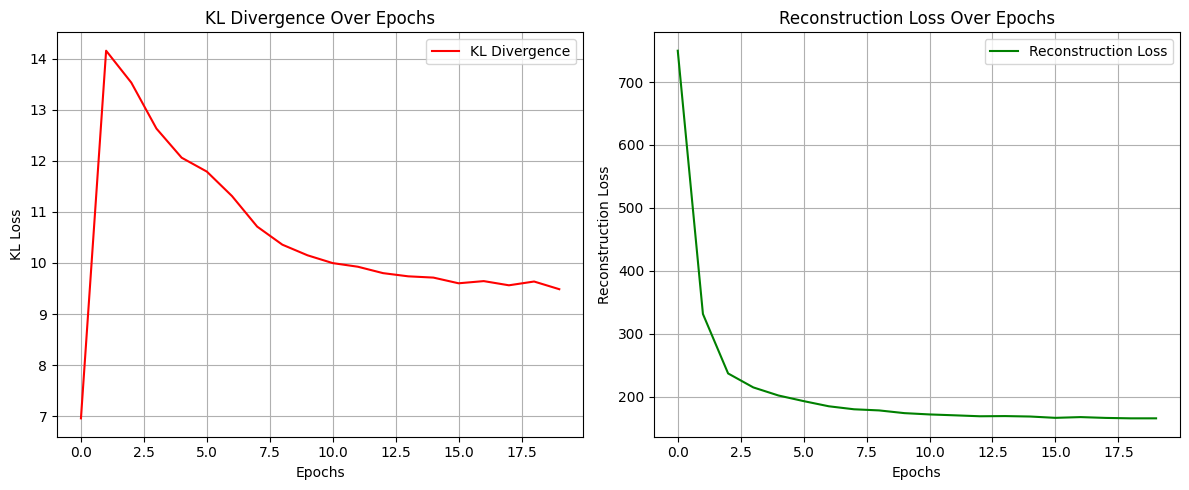

In [59]:
def plot_losses(kl_losses, recon_losses):
    
    loss_data = {
        "KL Divergence": (kl_losses, "KL Loss", "red"),
        "Reconstruction Loss": (recon_losses, "Reconstruction Loss", "green"),
    }

    fig, axes = plt.subplots(1, len(loss_data), figsize=(12, 5))  # 1 row, 2 columns

    for ax, (title, (loss_values, ylabel, color)) in zip(axes, loss_data.items()):
        ax.plot(loss_values, label=title, color=color)
        ax.set_xlabel("Epochs")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title} Over Epochs")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_losses(kl_losses, recon_losses)

In [60]:
vae.eval()
patch_size=16

In [61]:
def extract_patches(image, patch_size=16, stride=8):
    """
    Extract patches from the input image using a specified patch size and stride.
    
    Args:
        image (torch.Tensor): Input image tensor of shape (C, H, W).
        patch_size (int): The size of each patch.
        stride (int): The stride between patches.
    
    Returns:
        torch.Tensor: Extracted patches tensor of shape (-1, C, patch_size, patch_size).
    """
    _, channels, height, width = image.shape

    # Unfold the image into patches using a sliding window
    patches = image.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    
    # Rearrange dimensions to flatten patches into rows
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()
    patches = patches.view(-1, channels, patch_size, patch_size)

    return patches

In [62]:
def extract_latent_representations(data_loader, vae, patch_size=16, device="cuda", batch_size=512):
    vae.eval()
    all_latent_representations = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch = batch.to(device)

            for img_idx, img in enumerate(batch):
                img = img.unsqueeze(0)  # add batch dim

                patches = extract_patches(img, patch_size).to(device)

                patches = F.interpolate(patches, size=(128, 128), mode="bilinear", align_corners=False)

                latent_representations = torch.cat([
                    vae.module.encode(patches[i : i + batch_size])
                    for i in range(0, patches.shape[0], batch_size)
                ], dim=0)

                all_latent_representations.append(latent_representations)

    print(f"Processed {len(all_latent_representations)} images.")
    return all_latent_representations

In [63]:
latent_representations_per_image = extract_latent_representations(test_images, vae, patch_size=16, device="cuda")

Processed 3 images.


In [64]:
print(latent_representations_per_image[0].shape)

torch.Size([65025, 128])


In [65]:
def visualize_clusters(img, cluster_labels, patch_size=16, stride=8):
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()

    height, width = img.shape[1], img.shape[2]
    clustered_image = np.zeros((height, width))

    patch_idx = 0
    weight_matrix = np.zeros((height, width))  # To accumulate values for overlaps

    for i in range(0, height - patch_size + 1, stride):
        for j in range(0, width - patch_size + 1, stride):
            clustered_image[i:i + patch_size, j:j + patch_size] += cluster_labels[patch_idx]
            weight_matrix[i:i + patch_size, j:j + patch_size] += 1
            patch_idx += 1

    # Normalize overlapping regions
    clustered_image /= np.maximum(weight_matrix, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters with Stride")
    plt.show()

    return clustered_image

In [66]:
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_representations_per_image[0].cpu())
cluster_labels = gmm.predict(latent_representations_per_image[0].cpu())

unique_clusters = set(cluster_labels)
particle_group_label = min(unique_clusters, key=list(cluster_labels).count)
binary_cluster_labels = [1 if label == particle_group_label else 0 for label in cluster_labels]

In [67]:
latent_space_image = latent_representations_per_image[0].cpu()

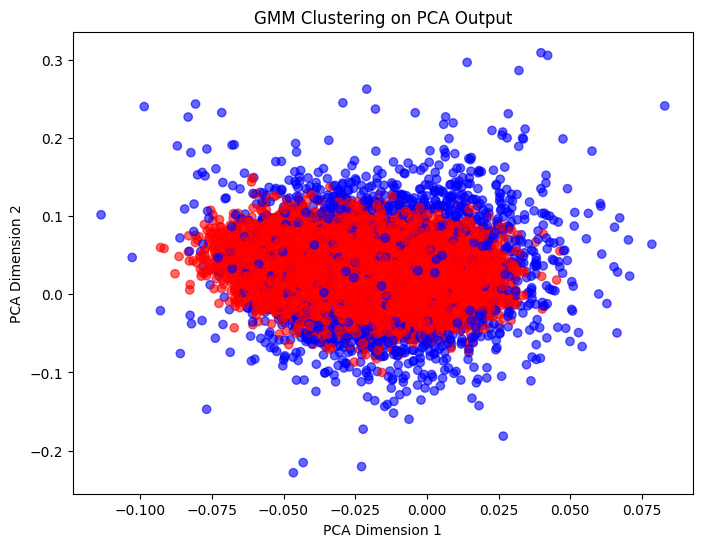

In [68]:
"""
from sklearn.preprocessing import StandardScaler

latent_space_image = latent_representations_per_image[0].cpu().numpy()
latent_space_normalized = StandardScaler().fit_transform(latent_space_image)
ls_pca, pca = apply_pca(latent_space_normalized, n_components=50)
print(f"Shape after PCA: {ls_pca.shape}")

"""
# Assign colors based on cluster labels (0: Noise, 1: Particles)
colors = np.array(['red', 'blue'])  # Two distinct colors for two clusters
colored_labels = np.array(binary_cluster_labels)

# Scatter plot to visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_image[:, 0], latent_space_image[:, 1], c=colors[colored_labels], alpha=0.6)
plt.title('GMM Clustering on PCA Output')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.show()

In [69]:
test_batch = next(iter(test_images))

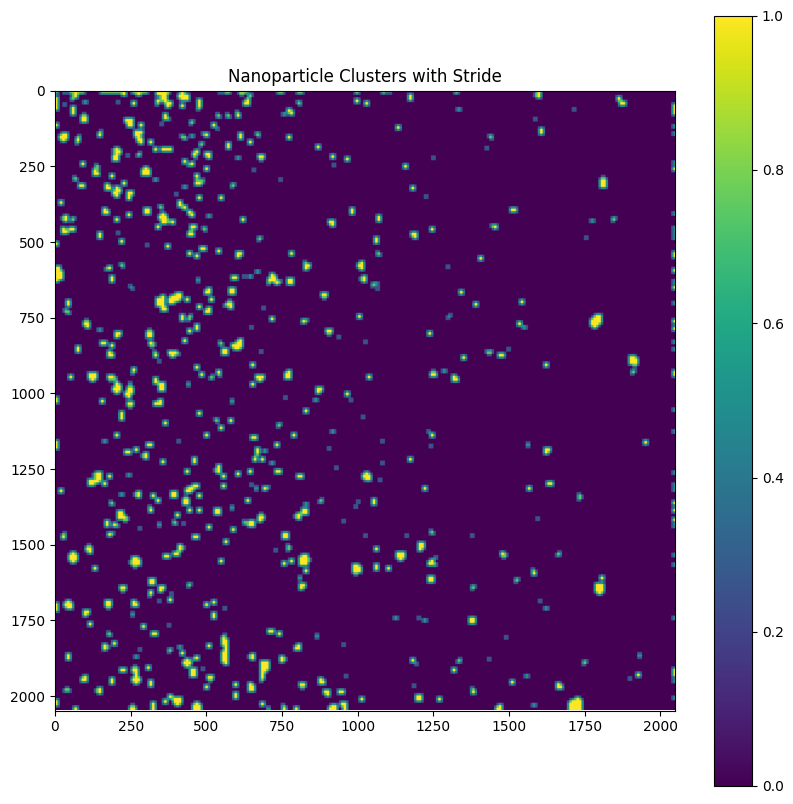

In [70]:
clustered_image = visualize_clusters(test_batch[0].cpu(), binary_cluster_labels, patch_size=16)

In [71]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def normalize_image(image):
    image = (image - image.min()) / (image.max() - image.min()) * 255
    return image.astype(np.uint8)

def label_clusters(sample_img, binary_cluster_labels, patch_size=16, stride=8, cluster_id=None, title="Cluster Contours"):
    img_array = sample_img.cpu().numpy().squeeze()
    img_h, img_w = img_array.shape[:2]
    
    # Normalize the input image
    image_np = normalize_image(img_array)
    
    # Initialize an empty grid for clusters and a weight matrix for normalization
    cluster_grid = np.zeros((img_h, img_w))
    weight_matrix = np.zeros((img_h, img_w))
    
    # Fill the cluster grid using overlapping patches
    patch_idx = 0
    for i in range(0, img_h - patch_size + 1, stride):
        for j in range(0, img_w - patch_size + 1, stride):
            cluster_grid[i:i + patch_size, j:j + patch_size] += binary_cluster_labels[patch_idx]
            weight_matrix[i:i + patch_size, j:j + patch_size] += 1
            patch_idx += 1
    
    # Normalize overlapping regions
    cluster_grid /= np.maximum(weight_matrix, 1)
    
    # Resize to match the original image dimensions
    resized_mask = cv2.resize(cluster_grid, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
    mask = (resized_mask == cluster_id).astype(np.uint8) if cluster_id is not None else (resized_mask > 0).astype(np.uint8)

    # Detect contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Overlay contours on the original image
    overlay = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(overlay, contours, -1, (255, 0, 0), 1)

    plt.figure(figsize=(12, 12))
    plt.imshow(overlay, cmap="gray")
    plt.title(f"Cluster {cluster_id}" if cluster_id is not None else title)
    plt.axis("off")
    plt.show()

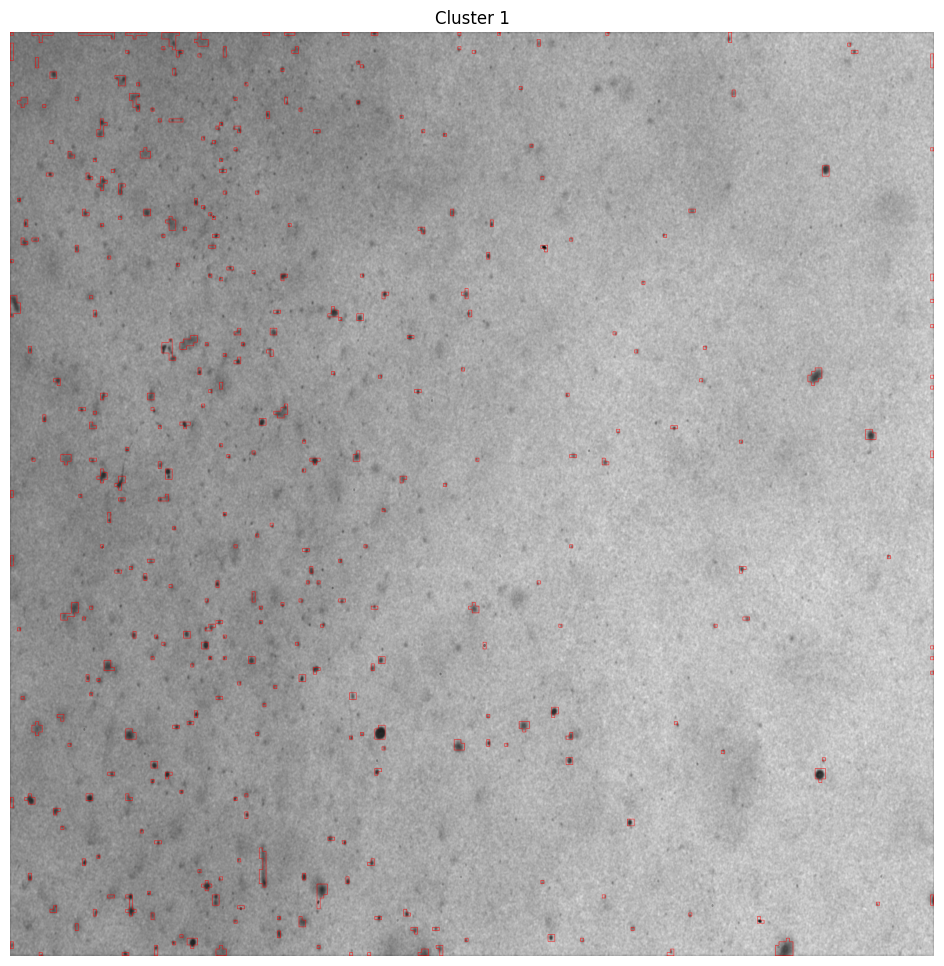

In [72]:
label_clusters(
    test_batch[0],
    binary_cluster_labels,
    patch_size,
    cluster_id=1,
)

In [38]:
import torch

def generate_z1_z2_from_clusters(latent_representations, cluster_labels):
    z1 = []
    z2 = []
    labels = []
    
    for i in range(len(latent_representations) - 1):
        z1_vector = latent_representations[i]
        z2_vector = latent_representations[i + 1]
        
        if cluster_labels[i] == cluster_labels[i + 1]:
            # Similar pairs (same cluster)
            z1.append(z1_vector)
            z2.append(z2_vector)
            labels.append(0)
        else:
            # Dissimilar pairs (different clusters)
            z1.append(z1_vector)
            z2.append(z2_vector)
            labels.append(1)
    
    z1_tensor = torch.stack(z1)
    z2_tensor = torch.stack(z2)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)
    
    # Save the tensors
    torch.save(z1_tensor, '../saved_models/z1_tensor.pt')
    torch.save(z2_tensor, '../saved_models/z2_tensor.pt')
    torch.save(labels_tensor, '../saved_models/labels_tensor.pt')
    
    return z1_tensor, z2_tensor, labels_tensor

# Example usage
latent_representations = latent_representations_per_image[2].cpu()  # From your code
z1, z2, labels = generate_z1_z2_from_clusters(latent_representations, cluster_labels)

print(f"z1 shape: {z1.shape}")
print(f"z2 shape: {z2.shape}")
print(f"Labels shape: {labels.shape}")

z1 shape: torch.Size([65024, 512])
z2 shape: torch.Size([65024, 512])
Labels shape: torch.Size([65024])


In [74]:
def generate_z1_z2_from_clusters(latent_representations, cluster_labels):
    z1 = []
    z2 = []
    labels = []

    for i in range(len(latent_representations) - 1):
        label1 = cluster_labels[i]
        label2 = cluster_labels[i + 1]

        # Skip background-background pairs
        if label1 == 0 and label2 == 0:
            continue

        z1_vector = latent_representations[i]
        z2_vector = latent_representations[i + 1]

        # Similar pair if in same cluster (but not both background)
        is_similar = int(label1 == label2)

        z1.append(z1_vector)
        z2.append(z2_vector)
        labels.append(is_similar)

    z1_tensor = torch.stack(z1)
    z2_tensor = torch.stack(z2)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    # Save if needed
    torch.save(z1_tensor, '../saved_models/z1_tensor.pt')
    torch.save(z2_tensor, '../saved_models/z2_tensor.pt')
    torch.save(labels_tensor, '../saved_models/labels_tensor.pt')

    return z1_tensor, z2_tensor, labels_tensor

latent_representations = latent_representations_per_image[2].cpu()  # From your code
z1, z2, labels = generate_z1_z2_from_clusters(latent_representations, cluster_labels)

print(f"z1 shape: {z1.shape}")
print(f"z2 shape: {z2.shape}")
print(f"Labels shape: {labels.shape}")

z1 shape: torch.Size([41740, 128])
z2 shape: torch.Size([41740, 128])
Labels shape: torch.Size([41740])


In [78]:
def generate_z1_z2_from_clusters(latent_representations, cluster_labels):
    z1 = []
    z2 = []
    labels = []

    for i in range(len(latent_representations) - 1):
        label1 = cluster_labels[i]
        label2 = cluster_labels[i + 1]

        # Skip background-background pairs (optional, but still valid)
        if label1 == 0 and label2 == 0:
            continue

        z1_vector = latent_representations[i]
        z2_vector = latent_representations[i + 1]

        # Only particle–particle pairs are similar (label = 0)
        if label1 == 1 and label2 == 1:
            is_similar = 0
        else:
            is_similar = 1

        z1.append(z1_vector)
        z2.append(z2_vector)
        labels.append(is_similar)

    z1_tensor = torch.stack(z1)
    z2_tensor = torch.stack(z2)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    # Save tensors
    torch.save(z1_tensor, '../saved_models/z1_tensor.pt')
    torch.save(z2_tensor, '../saved_models/z2_tensor.pt')
    torch.save(labels_tensor, '../saved_models/labels_tensor.pt')

    return z1_tensor, z2_tensor, labels_tensor


In [79]:
latent_representations = latent_representations_per_image[0].cpu()  # From your code
z1, z2, labels = generate_z1_z2_from_clusters(latent_representations, cluster_labels)

print(f"z1 shape: {z1.shape}")
print(f"z2 shape: {z2.shape}")
print(f"Labels shape: {labels.shape}")

z1 shape: torch.Size([41740, 128])
z2 shape: torch.Size([41740, 128])
Labels shape: torch.Size([41740])


In [80]:
print("Total pairs:", len(labels))
print("Similar:", (labels == 0).sum().item())
print("Dissimilar:", (labels == 1).sum().item())

Total pairs: 41740
Similar: 1555
Dissimilar: 40185
